### Column Label Dictionary

- date: Unixtime date when events occured.
- companyId
- jobId
- country: Country of job-posting.
- stateProvince: Name of the state or province of the job posting.
- city: Name of job posting city.
- avgOverallRating: Average rating of the company (1-5 stars), with 0s for non-rated companies.
- numReviews: Total number of reviews the company had.
- industry: Industry associated with the company.
- normTitle: The normalized / canonical job title.
- normTitleCategory: The category (similar to occupational category) of the norm title.
- descriptionCharacterLength: Number of characters in job description.
- descriptionWordCount: Number of words in job description.
- experienceRequired: Minimum experience required for the job in years.
- estimatedSalary: Estimated annual salary (0 when estimate not available).
- salaryCurrency: Salary currency.
- jobLanguage: Job language.
- supervisingJob: Whether this job is classified as a supervising job.
- licenseRequiredJob: Whether this job is classified as requiring a license.
- educationRequirements: The job's education requirement. Values ("None", "High School", "Higher Education").
- jobAgeDays: Age of job in days, based on job create date and on central timezone. Resets if job is 'refreshed'.
- clicks: The total number of clicks on the job on the date.
- localClicks: The total number of clicks on the job from a local user (same city and country) on the date.

## Importing Essential Libraries, Loading in Data & Dividing Dataset by Country

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import cluster

In [3]:
df = pd.read_csv('E:\josh_data_science\Vassar Datafest 2018\Dataset_and_FeatureDictionary\indeed_cleaned.csv', encoding='cp1252')

In [4]:
# Remove unnecessary column
del df['Unnamed: 0']

I will mainly focus on U.S. job postings

In [5]:
# Dividing dataset by country (Main focus on U.S.)
df_us = df.copy()[df.copy().country=='US']
# df_can = df.copy()[df.copy().country=='CA']
# df_ger = df.copy()[df.copy().country=='DE']

## K-Means Clustering on entire U.S. job postings by Industry (top 4 industries)

In [6]:
# Top 4 Industries with most number of values in U.S.
df_us.industry.value_counts()[:5]

UNKNOWN                             10163336
HEALTH_CARE                           429926
RETAIL                                151675
CONSULTING_AND_BUSINESS_SERVICES       86942
HUMAN_RESOURCES_AND_STAFFING           83578
Name: industry, dtype: int64

In [7]:
# Dividing df_us into Top 4 industry dataframes
df_us_healthcare = df_us.copy()[df_us.copy().industry=='HEALTH_CARE']
df_us_retail = df_us.copy()[df_us.copy().industry=='RETAIL'] 
df_us_consulting = df_us.copy()[df_us.copy().industry=='CONSULTING_AND_BUSINESS_SERVICES']
df_us_hr = df_us.copy()[df_us.copy().industry=='HUMAN_RESOURCES_AND_STAFFING']

I will apply KMeans clustering to estimatedSalary, experienceRequired, and the average number of clicks per job posting in healthcare.

I will first apply K-means to the Healthcare Industry and make the standard clusters

In [8]:
df_us_healthcare_for_cluster = pd.concat([df_us_healthcare.groupby('jobId').first().loc[:,['estimatedSalary','experienceRequired']], 
                               pd.DataFrame(df_us_healthcare.groupby('jobId').clicks.mean())], axis=1)

In [9]:
df_us_healthcare_for_cluster['averageClicks'] = df_us_healthcare_for_cluster['clicks']
del df_us_healthcare_for_cluster['clicks']

In [10]:
# from sklearn.preprocessing import MinMaxScaler

# Normalizing variables (Min/Max Normalization)

# scaler = MinMaxScaler()
# scaler.fit(df_us_for_cluster.estimatedSalary.reshape(-1,1))
# df_us_for_cluster.estimatedSalary = scaler.transform(df_us_for_cluster.estimatedSalary.reshape(-1,1))

# scaler2 = MinMaxScaler()
# scaler2.fit(df_us_for_cluster.experienceRequired.reshape(-1,1))
# df_us_for_cluster.experienceRequired = scaler2.transform(df_us_for_cluster.experienceRequired.reshape(-1,1))

# scaler3 = MinMaxScaler()
# scaler3.fit(df_us_for_cluster.averageClicks.reshape(-1,1))
# df_us_for_cluster.averageClicks = scaler3.transform(df_us_for_cluster.averageClicks.reshape(-1,1))

In [11]:
df_us_healthcare_for_cluster.head()

,estimatedSalary,experienceRequired,averageClicks
jobId,,,
job0000103,67900,3.721957,9.000000
job0000104,52300,3.099881,5.000000
job0000240,32300,4.000000,22.666667
job0000269,104200,5.000000,22.000000
job0000364,36800,2.481793,25.500000


##### Determining the optimal number of clusters: Elbow Method using "Score"

In [12]:
score = [cluster.KMeans(i).fit(df_us_healthcare_for_cluster).score(df_us_healthcare_for_cluster) for i in range(2, 6)]

Text(0.5,1,'Elbow curve')

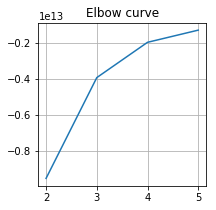

In [13]:
fig = plt.figure(figsize=(3,3))
plt.plot(range(2,6), score)
plt.grid(True)
plt.title('Elbow curve')

##### Determining the optimal number of clusters: Elbow Method using "Inertia"

In [14]:
distorsions = []

for k in range(2, 9):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(df_us_healthcare_for_cluster)
    distorsions.append(kmeans.inertia_)

Text(0.5,1,'Elbow curve')

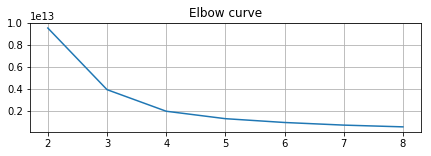

In [15]:
fig = plt.figure(figsize=(7, 2))
plt.plot(range(2, 9), distorsions)
plt.grid(True)
plt.title('Elbow curve')

4 seem to be the optimal number of clusters

###### HealthCare Industry

In [16]:
# 4 clusters
km_us_healthcare = cluster.KMeans(n_clusters = 4, random_state=42).fit(df_us_healthcare_for_cluster)

In [17]:
from mpl_toolkits.mplot3d import Axes3D

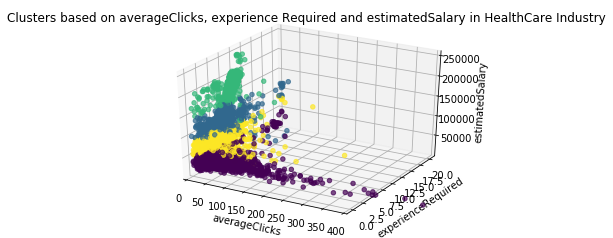

In [18]:
fig = plt.figure()
# ax = Axes3D(fig,  elev=48, azim=134)
ax = plt.axes(projection='3d')
labels = km_us_healthcare.labels_

ax.scatter(df_us_healthcare_for_cluster.as_matrix()[:, 2], df_us_healthcare_for_cluster.as_matrix()[:, 1], 
           df_us_healthcare_for_cluster.as_matrix()[:, 0], alpha=0.7,
           c=labels.astype(np.float), s=20)

# c=pd.Series(labels).replace({0:'Green',2:'Purple',1:'Yellow',3:'Blue'})

ax.set_xlim3d(0, 400)
ax.set_xlabel('averageClicks')
ax.set_ylabel('experienceRequired') 
ax.set_zlabel('estimatedSalary')
plt.title("Clusters based on averageClicks, experience Required and estimatedSalary in HealthCare Industry")
plt.show()

In [19]:
# Make "Cluster" column in df_us_healthcare_for_cluster
df_us_healthcare_for_cluster['Cluster'] = km_us_healthcare.labels_

In [20]:
# Add "Cluster" column to df_us_healthcare
df_us_healthcare['new_jobId'] = df_us_healthcare['jobId'] 
df_us_healthcare['new_jobId'] =\
df_us_healthcare['new_jobId'].\
map(dict(zip(df_us_healthcare_for_cluster.reset_index().jobId, df_us_healthcare_for_cluster.reset_index().Cluster)))
df_us_healthcare = df_us_healthcare.rename(columns={'new_jobId':'Cluster'})

In [22]:
km_us_healthcare.cluster_centers_

array([[  3.32573755e+04,   2.16811254e+00,   2.86873901e+01],
       [  1.07886295e+05,   5.05688189e+00,   1.82256272e+01],
       [  1.83016085e+05,   8.02956469e+00,   1.51058252e+01],
       [  6.58922094e+04,   3.04304505e+00,   1.82671781e+01]])

##### HealthCare Cluster 1 (Low Salary job postings)

In the 3d scatteplot, only the lowest salary cluster extends out along the averageClicks. In other words, **job postings that got the largest number of clicks were jobs that require little years of experience with little salary.** But there seems to be some points that have way higher averageClicks than the rest of the points in the same cluster. How are those points different? I will consider job postings that have averageClicks of 100 or higher as "outliers".

In [100]:
# Outliers in Cluster 1 (label 0) in Healthcare Industry
df_us_healthcare_cluster_1_outliers = \
df_us_healthcare.copy()\
[df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==0)').index.tolist())]

In [101]:
# Non-Outliers in Cluster 1 (label 0) in Healthcare Industry
df_us_healthcare_cluster_1_non_outliers = \
df_us_healthcare.copy()\
[~df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==0)').index.tolist())]

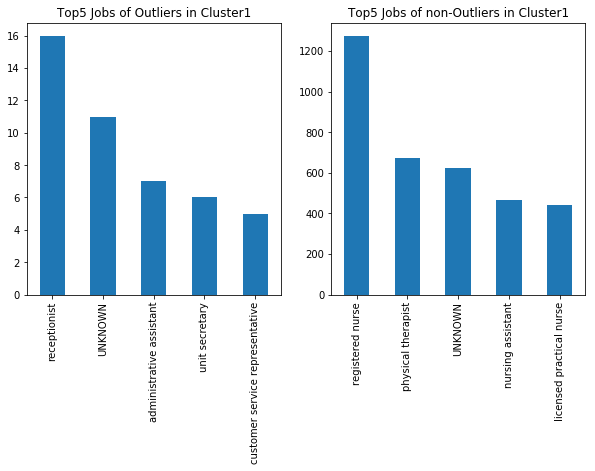

In [102]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax1, title='Top5 Jobs of Outliers in Cluster1')
df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax2, title='Top5 Jobs of non-Outliers in Cluster1')

In [103]:
from scipy.stats import median_test
from scipy.stats import ttest_ind

In [105]:
# avgOverallRating comparison
print("Outliers:", df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean())

Outliers: 3.420283018867923 / non-Outliers: 3.4159903897490076


In [91]:
median_test(df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().avgOverallRating,
           df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating)[1]

0.36431865700282318

In [106]:
ttest_ind(df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().avgOverallRating,
           df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating, equal_var=False)

Ttest_indResult(statistic=0.0615341264646301, pvalue=0.95099046710334068)

In [109]:
# numReviews comparison
# Used median instead of mean as representative value since numReviews column is skewed 
print("Outliers:", df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().numReviews.median(),"/", "non-Outliers:",
df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().numReviews.median())

Outliers: 107.0 / non-Outliers: 92.0


In [110]:
median_test(df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().numReviews,
           df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().numReviews)[1]

0.010067498246543785

In [111]:
print("Outliers:", df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median())

Outliers: 303.5 / non-Outliers: 321.0


In [112]:
median_test(df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().descriptionWordCount,
           df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount)[1]

0.64309397722434891

In [114]:
print("Outliers:", df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median())

Outliers: 1884.5 / non-Outliers: 1889.5


In [115]:
median_test(df_us_healthcare_cluster_1_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength,
           df_us_healthcare_cluster_1_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength)[1]

1.0

Jobs like receptionist, unit secretary, assistant and data entry clerk have higher "job visibility" or more "interest from applicants" than other jobs in the same cluster like registered nurse or physical therapist. Why? One explanation could be that *job postings with higher averageClicks tend to have higher company rating and more information about the company(higher number of reviews) as demonstrated by higher avgOverallRating and numReview median values for outliers.* However, *only the median-test (t-test equivalent for median comparison)/t-test for "numReviews" had p-values below the significance value of 0.05.* Thus, **in the lower salary cluster, job postings that have higher number of reviews of companies are likely to receive more clicks from applicants.**

##### HealthCare Cluster 2 (Medium Salary job postings)

In [116]:
# Outliers in Cluster 2 (label 3) in Healthcare Industry
df_us_healthcare_cluster_2_outliers = \
df_us_healthcare.copy()\
[df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==3)').index.tolist())]

In [117]:
# Non-Outliers in Cluster 2 (label 3) in Healthcare Industry
df_us_healthcare_cluster_2_non_outliers = \
df_us_healthcare.copy()\
[~df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==3)').index.tolist())]

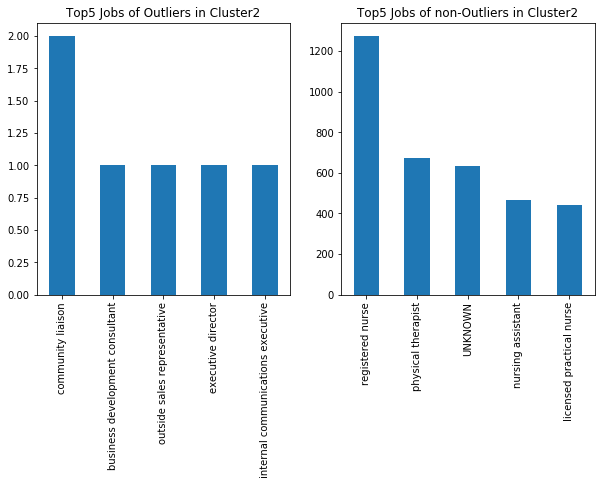

In [118]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax1, title='Top5 Jobs of Outliers in Cluster2')
df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax2, title='Top5 Jobs of non-Outliers in Cluster2')

In [120]:
# avgOverallRating comparison
print("Outliers:", df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean())

Outliers: 3.481481481481481 / non-Outliers: 3.4159450171820755


In [121]:
ttest_ind(df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().avgOverallRating,
           df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating, equal_var=False)

Ttest_indResult(statistic=0.4014562238311935, pvalue=0.69134851154790378)

In [122]:
# numReviews comparison
# Used median instead of mean as representative value since numReviews column is skewed 
print("Outliers:", df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().numReviews.median(),"/", "non-Outliers:",
df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().numReviews.median())

Outliers: 101.0 / non-Outliers: 93.0


In [123]:
median_test(df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().numReviews,
           df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().numReviews)[1]

0.099898495074064078

In [124]:
print("Outliers:", df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median())

Outliers: 487.0 / non-Outliers: 321.0


In [125]:
median_test(df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().descriptionWordCount,
           df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount)[1]

0.00051330825806575775

In [126]:
print("Outliers:", df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median())

Outliers: 3171.0 / non-Outliers: 1888.0


In [127]:
median_test(df_us_healthcare_cluster_2_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength,
           df_us_healthcare_cluster_2_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength)[1]

0.00011727771442512527

In the medium salary cluster, job postings like community liaison, business development consultant & outside sales representative received higher volume of clicks than the majority of other job postings including registered nurse and physical therapist. Unlike the case of cluster 1, number of reviews and company's rating didn't matter as much. Instead, *the length of the description played a role with (p-values lower than 0.05).* **The job postings that received more clicks in this medium salary cluster are more likely to have longer job descriptions than others in the same cluster.**

###### HealthCare Cluster 3 (High Salary job postings)

In [130]:
# Outliers in Cluster 3 (label 1) in Healthcare Industry
df_us_healthcare_cluster_3_outliers = \
df_us_healthcare.copy()\
[df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==1)').index.tolist())]

In [131]:
# Non-Outliers in Cluster 3 (label 1) in Healthcare Industry
df_us_healthcare_cluster_3_non_outliers = \
df_us_healthcare.copy()\
[~df_us_healthcare.copy().jobId.isin(df_us_healthcare_for_cluster.query('(averageClicks > 100) & (Cluster==1)').index.tolist())]

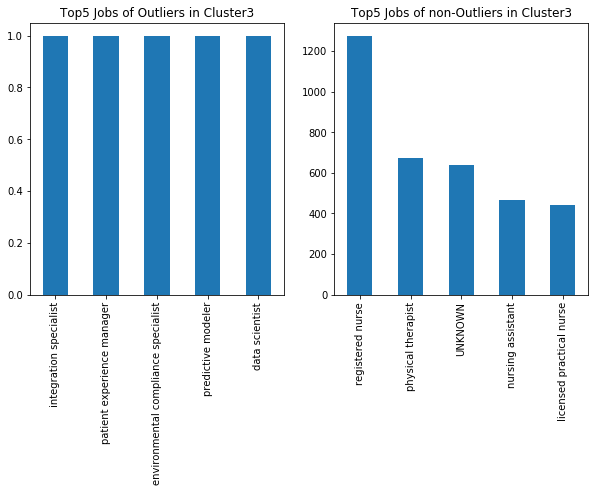

In [133]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax1, title='Top5 Jobs of Outliers in Cluster3')
df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().normTitle.value_counts()[:5].\
plot('bar', ax=ax2, title='Top5 Jobs of non-Outliers in Cluster3')

In [134]:
# avgOverallRating comparison
print("Outliers:", df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating.mean())

Outliers: 3.8875 / non-Outliers: 3.415839231012938


In [136]:
ttest_ind(df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().avgOverallRating,
           df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().avgOverallRating, equal_var=False)

Ttest_indResult(statistic=8.0444037748343256, pvalue=7.0962646838182832e-05)

In [137]:
# numReviews comparison
# Used median instead of mean as representative value since numReviews column is skewed 
print("Outliers:", df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().numReviews.median(),"/", "non-Outliers:",
df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().numReviews.median())

Outliers: 89.0 / non-Outliers: 93.0


In [138]:
median_test(df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().numReviews,
           df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().numReviews)[1]

0.76651682817935396

In [139]:
print("Outliers:", df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount.median())

Outliers: 527.5 / non-Outliers: 321.0


In [140]:
median_test(df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().descriptionWordCount,
           df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().descriptionWordCount)[1]

0.076390375475712771

In [141]:
print("Outliers:", df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median(),"/", 
      "non-Outliers:",df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength.median())

Outliers: 3687.0 / non-Outliers: 1889.0


In [142]:
median_test(df_us_healthcare_cluster_3_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength,
           df_us_healthcare_cluster_3_non_outliers.groupby(['companyId','jobId']).first().descriptionCharacterLength)[1]

0.077037439585006875

Not much of a statistical difference can be found between job postings that get exceptionally high clicks and others that get average clicks in Cluster 3 (High Salary Cluster)

###### HealthCare Cluster 4 (Ultra High Salary job postings)

In the 3d scatter plot above, the Ultra High Salary cluster seems to be heading upwards in a linear manner. Does this imply some kind of relationship among variables? Let's examine this cluster's correlation values.

In [144]:
df_us_healthcare_for_cluster.query('Cluster==2').loc[:,['estimatedSalary','experienceRequired','averageClicks']].corr()

,estimatedSalary,experienceRequired,averageClicks
estimatedSalary,1.000000,0.504024,-0.116217
experienceRequired,0.504024,1.000000,-0.110771
averageClicks,-0.116217,-0.110771,1.000000


According to the correlation table above, the estimatedSalary and exprienceRequired have strong positive linear correlation with each other. Hence, **in the ultra high salary cluster, if the job posting requires higher number of years of experience, it is likely that the pay will be stronger too. This correlation between the experienceRequired and estimatedSalary becomes stronger as the salary for the job increases while it decreases for the opposite case. The correlation values for other clusters are as follow and they illustrate this point:**

In [155]:
print('High Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary:', 
      df_us_healthcare_for_cluster.query('Cluster==1').loc[:,['estimatedSalary','experienceRequired','averageClicks']].corr().iloc[1,0])
print('Medium Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary:', 
      df_us_healthcare_for_cluster.query('Cluster==3').loc[:,['estimatedSalary','experienceRequired','averageClicks']].corr().iloc[1,0])
print('Low Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary:', 
      df_us_healthcare_for_cluster.query('Cluster==0').loc[:,['estimatedSalary','experienceRequired','averageClicks']].corr().iloc[1,0])
print("The correlation values become smaller as we move onto the next cluster with lower salaries")

High Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary: 0.320920272045
Medium Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary: 0.210899110546
Low Salary Cluster - Correlation of experienceRequired v.s. estimatedSalary: 0.20460774415
The correlation values become smaller as we move onto the next cluster with lower salaries


**The implication is - if an applicant wants to get a new job with considerate amount of hikes in salary(e.g. low salary to high salary, skipping medium salary), companies will require way more work experience (effort) than that person thought would be necessary. The graph below also illustrates this point.**

The graph gets steeper as it moves onto the next cluster with higher salary base


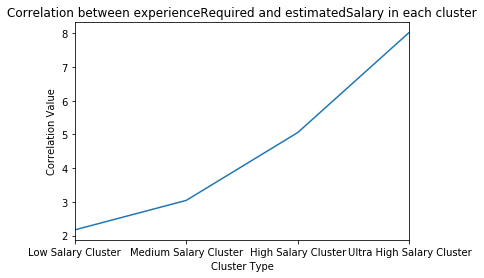

In [177]:
pd.Series([df_us_healthcare_for_cluster.query('Cluster==0').experienceRequired.mean(),
           df_us_healthcare_for_cluster.query('Cluster==3').experienceRequired.mean(),
           df_us_healthcare_for_cluster.query('Cluster==1').experienceRequired.mean(),
           df_us_healthcare_for_cluster.query('Cluster==2').experienceRequired.mean()]).plot()
plt.title("Correlation between experienceRequired and estimatedSalary in each cluster")
plt.xlabel('Cluster Type')
plt.xticks(np.arange(4),('Low Salary Cluster','Medium Salary Cluster','High Salary Cluster','Ultra High Salary Cluster'))
plt.ylabel('Correlation Value')
print("The graph gets steeper as it moves onto the next cluster with higher salary base")

Let's see how the job postings in the other three industries are classified into the clusters I made based on the healthcare industry.

###### Retail Industry

In [178]:
df_us_retail_for_cluster = pd.concat([df_us_retail.groupby('jobId').first().loc[:,['estimatedSalary','experienceRequired']], 
                               pd.DataFrame(df_us_retail.groupby('jobId').clicks.mean())], axis=1)

In [179]:
df_us_retail_for_cluster['averageClicks'] = df_us_retail_for_cluster['clicks']
del df_us_retail_for_cluster['clicks']

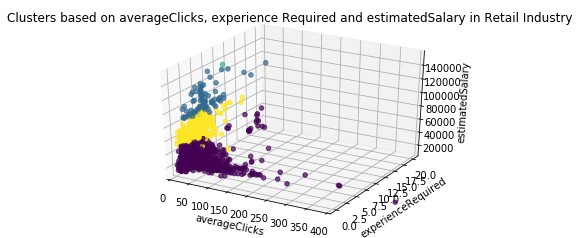

In [180]:
fig = plt.figure()
# ax = Axes3D(fig,  elev=48, azim=134)
ax = plt.axes(projection='3d')
labels = km_us_healthcare.predict(df_us_retail_for_cluster)

ax.scatter(df_us_retail_for_cluster.as_matrix()[:, 2], df_us_retail_for_cluster.as_matrix()[:, 1], 
           df_us_retail_for_cluster.as_matrix()[:, 0], alpha=0.7,
           c=labels.astype(np.float), s=20)

ax.set_xlim3d(0, 400)
ax.set_xlabel('averageClicks')
ax.set_ylabel('experienceRequired') 
ax.set_zlabel('estimatedSalary')
plt.title("Clusters based on averageClicks, experience Required and estimatedSalary in Retail Industry")
plt.show()

###### Consulting Industry

In [181]:
df_us_consulting_for_cluster = pd.concat([df_us_consulting.groupby('jobId').first().loc[:,['estimatedSalary','experienceRequired']], 
                               pd.DataFrame(df_us_consulting.groupby('jobId').clicks.mean())], axis=1)

In [182]:
df_us_consulting_for_cluster['averageClicks'] = df_us_consulting_for_cluster['clicks']
del df_us_consulting_for_cluster['clicks']

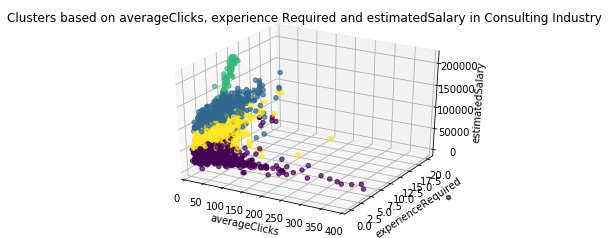

In [183]:
fig = plt.figure()
# ax = Axes3D(fig,  elev=48, azim=134)
ax = plt.axes(projection='3d')
labels = km_us_healthcare.predict(df_us_consulting_for_cluster)

ax.scatter(df_us_consulting_for_cluster.as_matrix()[:, 2], df_us_consulting_for_cluster.as_matrix()[:, 1], 
           df_us_consulting_for_cluster.as_matrix()[:, 0], alpha=0.7,
           c=labels.astype(np.float), s=20)

ax.set_xlim3d(0, 400)
ax.set_xlabel('averageClicks')
ax.set_ylabel('experienceRequired') 
ax.set_zlabel('estimatedSalary')
plt.title("Clusters based on averageClicks, experience Required and estimatedSalary in Consulting Industry")
plt.show()

###### HR Industry

In [184]:
df_us_hr_for_cluster = pd.concat([df_us_hr.groupby('jobId').first().loc[:,['estimatedSalary','experienceRequired']], 
                               pd.DataFrame(df_us_hr.groupby('jobId').clicks.mean())], axis=1)

In [185]:
df_us_hr_for_cluster['averageClicks'] = df_us_hr_for_cluster['clicks']
del df_us_hr_for_cluster['clicks']

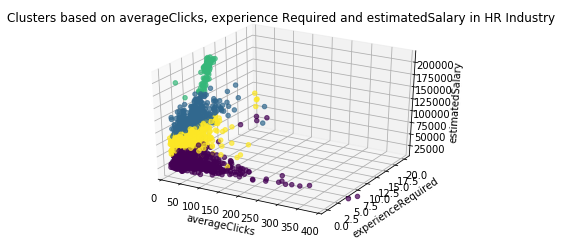

In [186]:
fig = plt.figure()
# ax = Axes3D(fig,  elev=48, azim=134)
ax = plt.axes(projection='3d')
labels = km_us_healthcare.predict(df_us_hr_for_cluster)

ax.scatter(df_us_hr_for_cluster.as_matrix()[:, 2], df_us_hr_for_cluster.as_matrix()[:, 1], 
           df_us_hr_for_cluster.as_matrix()[:, 0], alpha=0.7,
           c=labels.astype(np.float), s=20)

ax.set_xlim3d(0, 400)
ax.set_xlabel('averageClicks')
ax.set_ylabel('experienceRequired') 
ax.set_zlabel('estimatedSalary')
plt.title("Clusters based on averageClicks, experience Required and estimatedSalary in HR Industry")
plt.show()

From the 3d scatter plots above, we can see that these other three industries also share similar traits with the healthcare industry (e.g. job postings with higest averageClicks are concentrated in lower salary clusters, linear correlation between experienceRequired & estimatedSalary in the 4th cluster etc.). Minor differences include:
- Retail Industry doesn't even have the 4th cluster because the overall estimatedSalary is way lower than that of the healthcare sector
- 4th cluster(Ultra High Salary Cluster) does exist in Consulting and HR but job postings that pay 200K ~ 250K are unique to the healthcare sector
- Consulting and HR industries have stronger correlation between experienceRequired & estimatedSalary in the 4th cluster than the healthcare sector